In [1]:
# torch and torchvision imports
import torch, torch.nn as nn, torch.optim as optim
from torchmetrics.classification import MultilabelAUROC
import numpy as np,  matplotlib.pyplot as plt, pandas as pd
from ResnetModel import *
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter()
device

2023-11-30 09:00:40.733756: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 09:00:40.764467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 09:00:40.764499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 09:00:40.765232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 09:00:40.770484: I tensorflow/core/platform/cpu_feature_guar

device(type='cuda')

### Loading and Preparing Data

In [2]:
X_train = torch.from_numpy(np.transpose(np.load('X_train.npy'), axes = (0,2,1))).float()
X_test = torch.from_numpy(np.transpose(np.load('X_test.npy'), axes = (0,2,1))).float()
y_train = pd.read_pickle('y_train.pickle').to_numpy()
y_test = pd.read_pickle('y_test.pickle').to_numpy()

class_list = []
for classes in y_train:
    class_list += classes 
class_list = set(class_list)
class_list
diagSupclassDict = {val:i for i, val in enumerate(class_list)}
diagSupclassDict['Nodiag'] = 5
print(diagSupclassDict)

train_label_mapping = torch.zeros((X_train.shape[0], len(diagSupclassDict)))
print(f"-"*(1+30+5+35))
for i, classes in enumerate(y_train):
    for diagclass in classes:
        train_label_mapping[i, diagSupclassDict[diagclass]] = 1
    if len(classes) == 0:
        train_label_mapping[i, diagSupclassDict['Nodiag']] = 1
    
    print(f"|  {str(y_train[i]):>30}  |  {str(train_label_mapping[i]):<30}   |")

test_label_mapping = torch.zeros((X_test.shape[0], len(diagSupclassDict)))
print(f"-"*(1+30+5+35))
for i, classes in enumerate(y_test):
    for diagclass in classes:
        test_label_mapping[i, diagSupclassDict[diagclass]] = 1
    if len(classes) == 0:
        test_label_mapping[i, diagSupclassDict['Nodiag']] = 1
    
    print(f"|  {str(y_train[i]):>30}  |  {str(test_label_mapping[i]):<30}   |")

train_dataset = torch.utils.data.TensorDataset(X_train, train_label_mapping)
test_dataset = torch.utils.data.TensorDataset(X_test, test_label_mapping)
x = X_train[0:1]
print(x.shape)

{'HYP': 0, 'NORM': 1, 'CD': 2, 'MI': 3, 'STTC': 4, 'Nodiag': 5}
-----------------------------------------------------------------------
|                        ['NORM']  |  tensor([0., 1., 0., 0., 0., 0.])   |
|                        ['NORM']  |  tensor([0., 1., 0., 0., 0., 0.])   |
|                        ['NORM']  |  tensor([0., 1., 0., 0., 0., 0.])   |
|                        ['NORM']  |  tensor([0., 1., 0., 0., 0., 0.])   |
|                        ['NORM']  |  tensor([0., 1., 0., 0., 0., 0.])   |
|                        ['NORM']  |  tensor([0., 1., 0., 0., 0., 0.])   |
|                        ['NORM']  |  tensor([0., 1., 0., 0., 0., 0.])   |
|                          ['MI']  |  tensor([0., 0., 0., 1., 0., 0.])   |
|                        ['NORM']  |  tensor([0., 1., 0., 0., 0., 0.])   |
|                        ['NORM']  |  tensor([0., 1., 0., 0., 0., 0.])   |
|                        ['NORM']  |  tensor([0., 1., 0., 0., 0., 0.])   |
|                        ['NORM']  |  t

### Creating the Resnet Model

In [3]:
model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).float()
print(summary(model.to(device), (12,1000)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 500]           5,376
              ReLU-2              [-1, 64, 500]               0
       BatchNorm1d-3              [-1, 64, 500]             128
         MaxPool1d-4              [-1, 64, 250]               0
            Conv1d-5              [-1, 64, 250]           4,096
              ReLU-6              [-1, 64, 250]               0
       BatchNorm1d-7              [-1, 64, 250]             128
            Conv1d-8              [-1, 64, 250]          12,288
              ReLU-9              [-1, 64, 250]               0
      BatchNorm1d-10              [-1, 64, 250]             128
           Conv1d-11             [-1, 256, 250]          16,384
      BatchNorm1d-12             [-1, 256, 250]             512
           Conv1d-13             [-1, 256, 250]          16,384
      BatchNorm1d-14             [-1, 2

In [4]:
(4*1024-107.88)/107.88 #Max batch size

36.96811271783463

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True)

In [6]:
"""Test AUC metric"""
ml_auroc = MultilabelAUROC(num_labels=len(diagSupclassDict), average="macro", thresholds=None)
# ml_auroc(model(X_train[0:10].to(device)), train_label_mapping[0:10].to(device).int())

### Finding Max Learning rate

In [ ]:
criterion = nn.BCELoss()
epochs = 10
model = model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).float()
model = model.to(device)
lr = 1e-6
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

In [ ]:
train_loss = []
lrs = []

for i, (signal, labels) in enumerate(train_loader):
    signal = signal.to(device)
    labels = labels.to(device)
    output = model(signal)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    train_loss.append(loss.item())
    lrs.append(lr)
    lr *= 1.1

    for g in optimizer.param_groups:
        g['lr'] = lr 

    optimizer.step()

    if i > 200 or lr > 1:
        break

lrs = np.array(lrs)
train_loss = np.array(train_loss)

lr_max = lrs[np.where(train_loss == train_loss.min())[0]]

fig = plt.figure()
plt.plot(lrs, train_loss)
plt.plot(lr_max, train_loss[lrs == lr_max], '.r')
plt.show()


In [ ]:
lr_max

In [7]:
lr_max = 0.135/10
lr = lr_max
epochs = 10
criterion = nn.BCELoss()
epochs = 10
model = model = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=6).float()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=1e-4)

for g in optimizer.param_groups:
    g['lr'] = lr

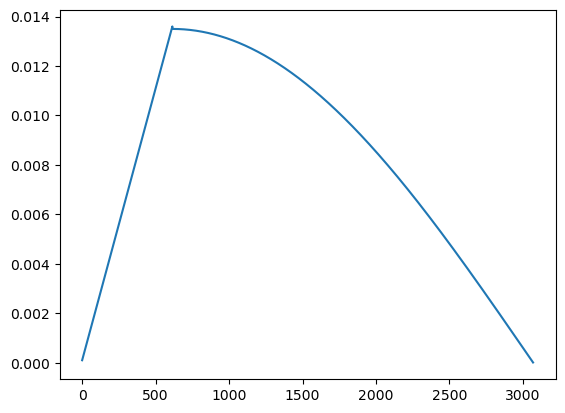

In [8]:
lrs = []
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
for t in range(T_max):
    if t <= T_0:
        lr = 10**(-4) + (t/T_0)*lr_max  
    else: 
        lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6)
    lrs.append(lr)

fig = plt.figure()
plt.plot(lrs)
plt.show()


In [9]:
lr =lr_max

Step: 1/307  |  Train loss: 0.6956  |  Train AUC: 0.6928


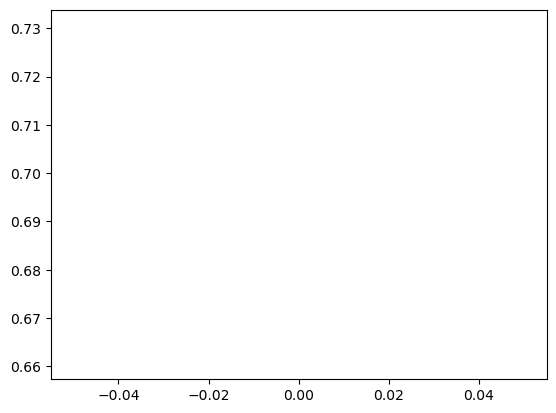

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Step: 101/307  |  Train loss: 0.4675  |  Train AUC: 0.7366


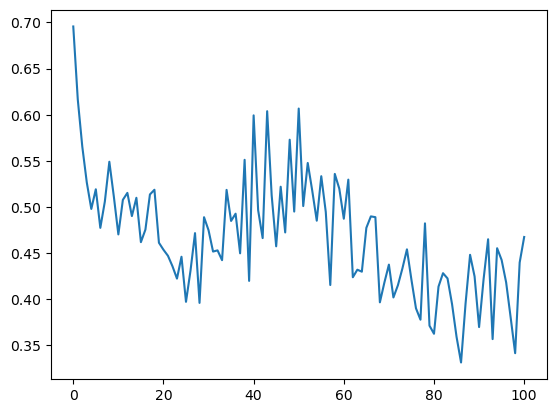

Step: 201/307  |  Train loss: 0.2755  |  Train AUC: 0.9288


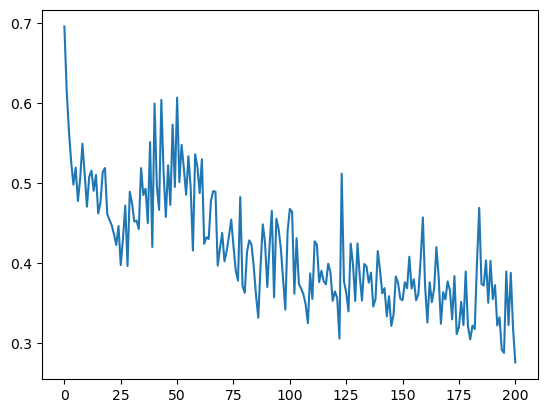

Step: 301/307  |  Train loss: 0.3399  |  Train AUC: 0.8205


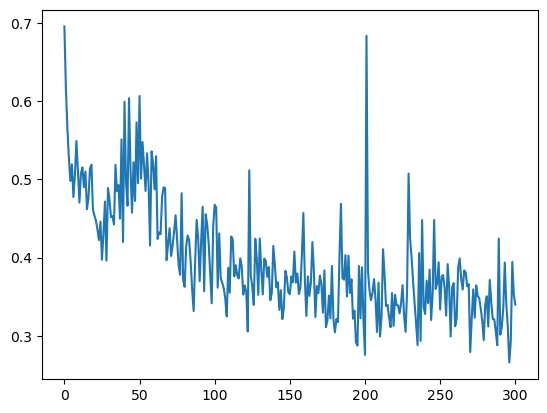

Step: 1/307  |  Train loss: 0.3810  |  Train AUC: 0.6908


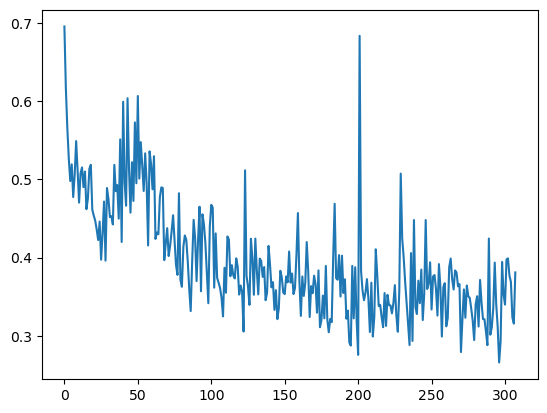

Step: 101/307  |  Train loss: 0.3254  |  Train AUC: 0.8737


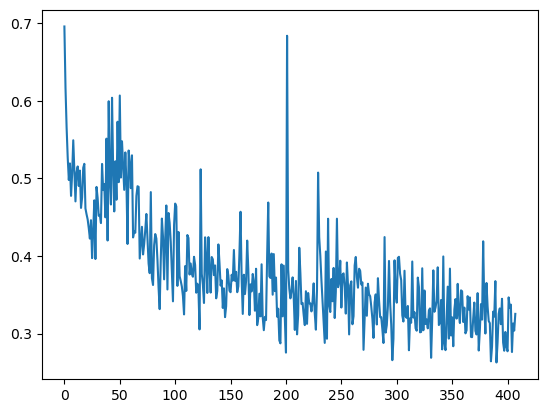

Step: 201/307  |  Train loss: 0.3155  |  Train AUC: 0.8932


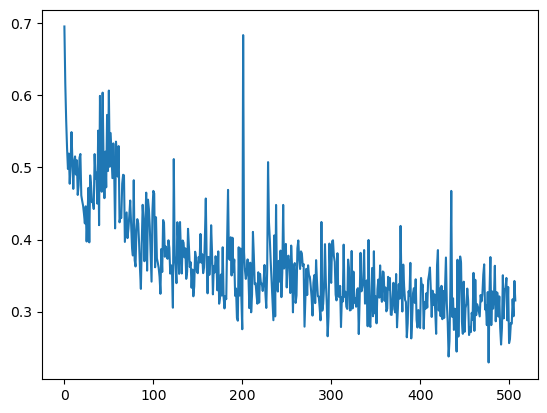

Step: 301/307  |  Train loss: 0.2977  |  Train AUC: 0.8694


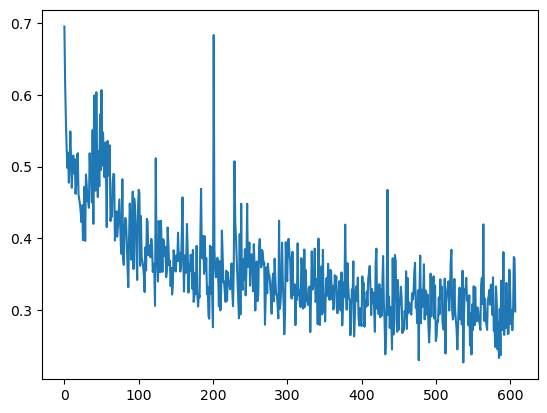

Step: 1/307  |  Train loss: 0.2480  |  Train AUC: 0.7544


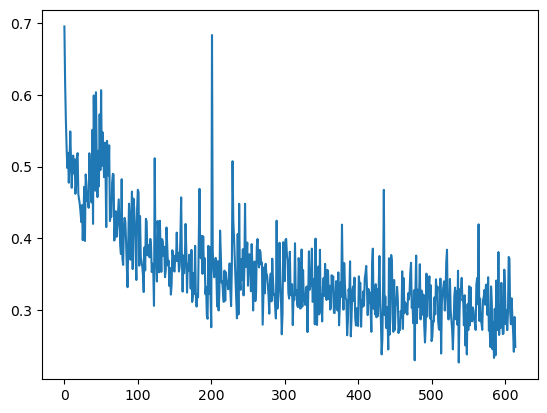

Step: 101/307  |  Train loss: 0.3002  |  Train AUC: 0.8698


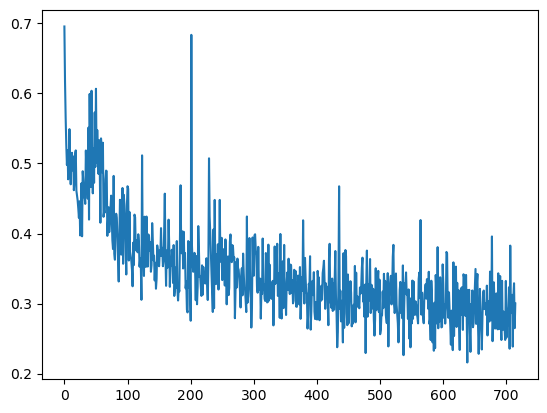

Step: 201/307  |  Train loss: 0.2613  |  Train AUC: 0.9074


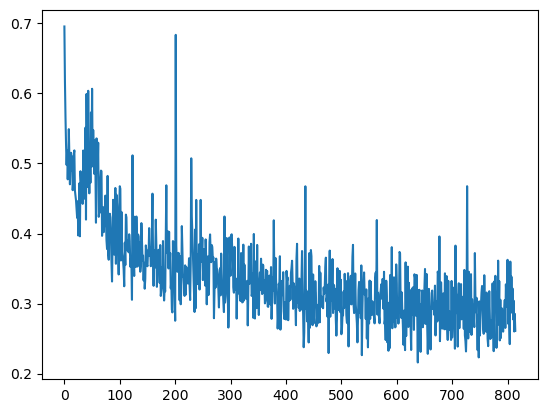

Step: 301/307  |  Train loss: 0.3089  |  Train AUC: 0.7195


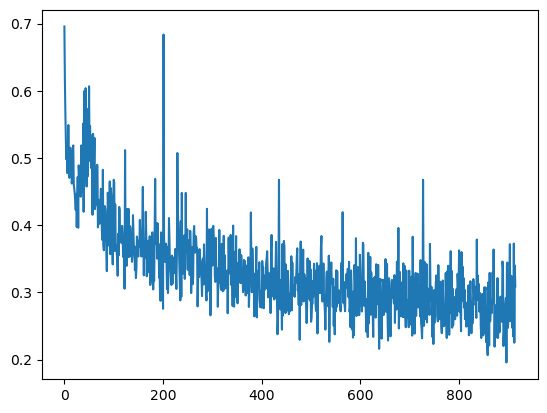

Step: 1/307  |  Train loss: 0.2744  |  Train AUC: 0.9145


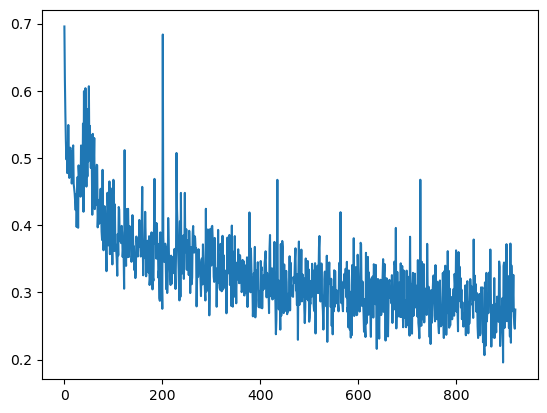

Step: 101/307  |  Train loss: 0.2704  |  Train AUC: 0.9333


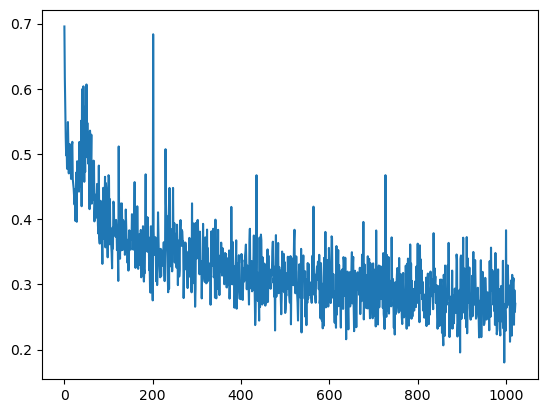

Step: 201/307  |  Train loss: 0.3028  |  Train AUC: 0.8907


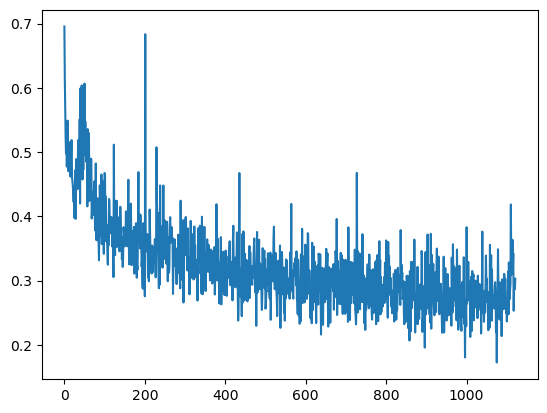

Step: 301/307  |  Train loss: 0.2704  |  Train AUC: 0.8985


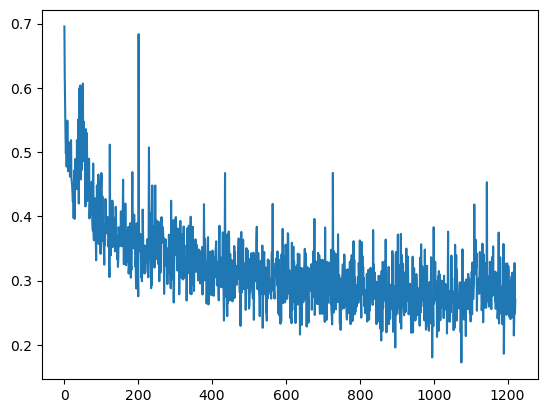

Step: 1/307  |  Train loss: 0.2963  |  Train AUC: 0.7230


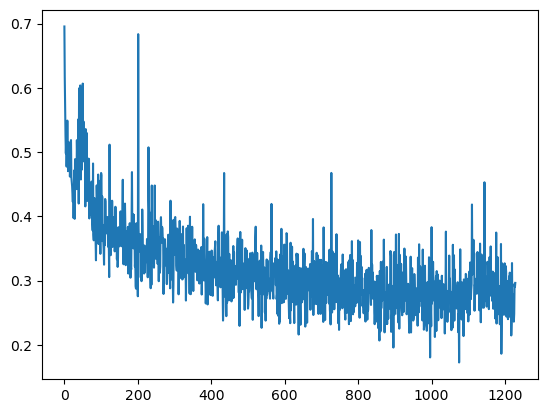

Step: 101/307  |  Train loss: 0.2127  |  Train AUC: 0.9421


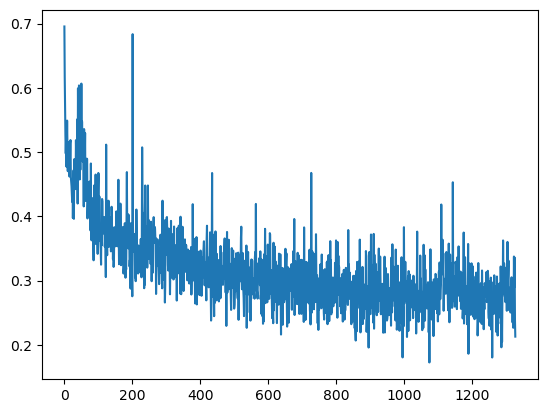

Step: 201/307  |  Train loss: 0.2124  |  Train AUC: 0.9537


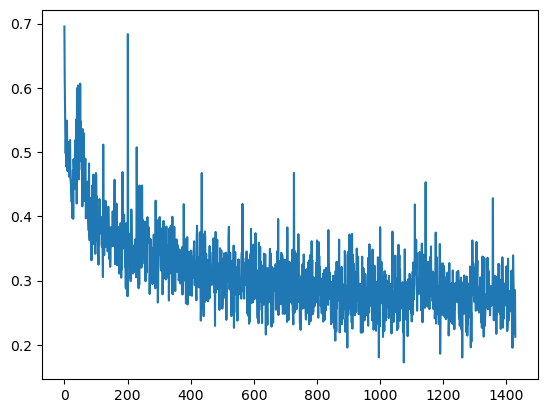

Step: 301/307  |  Train loss: 0.2690  |  Train AUC: 0.7630


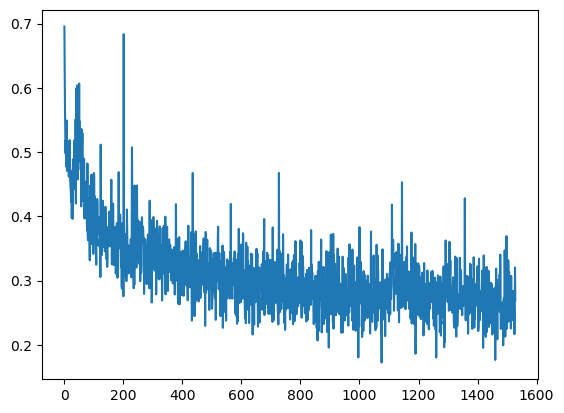

Step: 1/307  |  Train loss: 0.2950  |  Train AUC: 0.8451


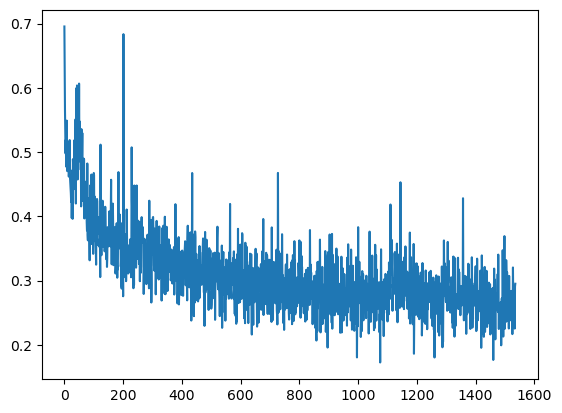

Step: 101/307  |  Train loss: 0.2771  |  Train AUC: 0.7377


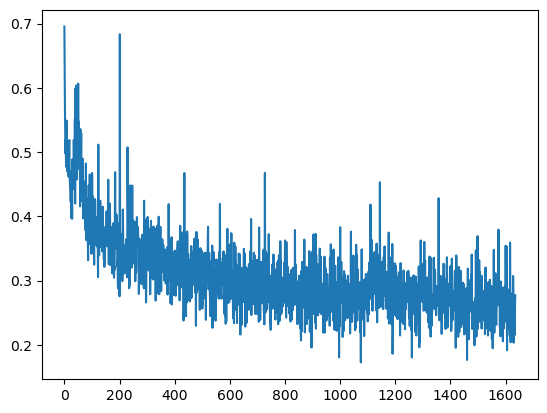

Step: 201/307  |  Train loss: 0.2300  |  Train AUC: 0.9382


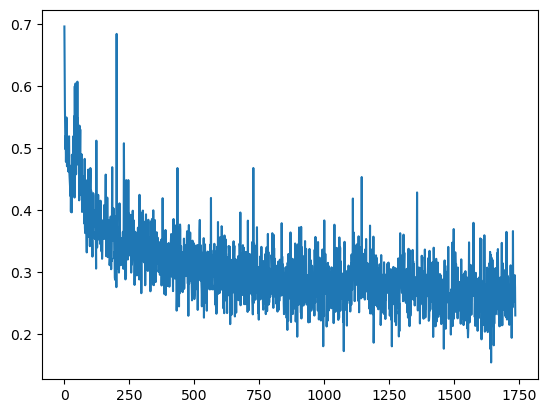

Step: 301/307  |  Train loss: 0.2424  |  Train AUC: 0.7601


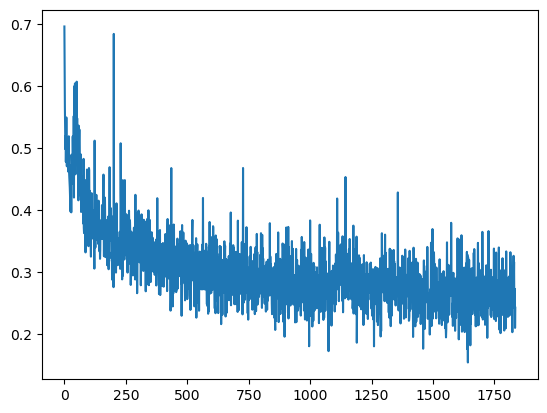

Step: 1/307  |  Train loss: 0.2828  |  Train AUC: 0.9079


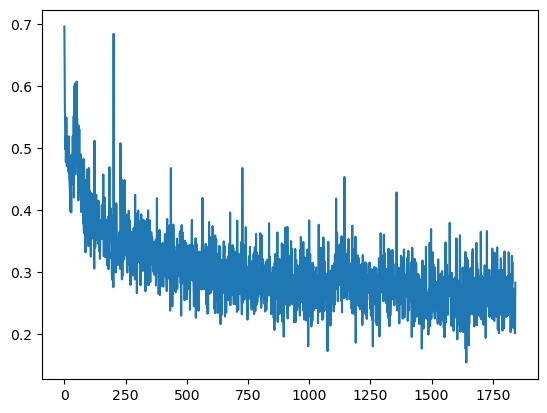

Step: 101/307  |  Train loss: 0.2100  |  Train AUC: 0.7823


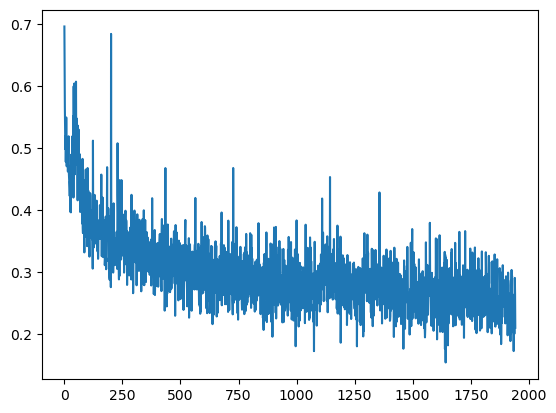

Step: 201/307  |  Train loss: 0.3214  |  Train AUC: 0.8811


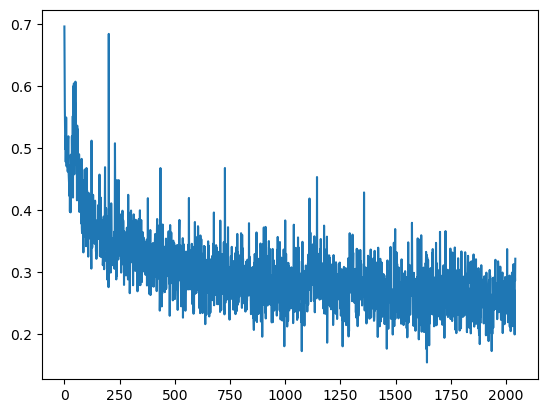

Step: 301/307  |  Train loss: 0.1836  |  Train AUC: 0.7858


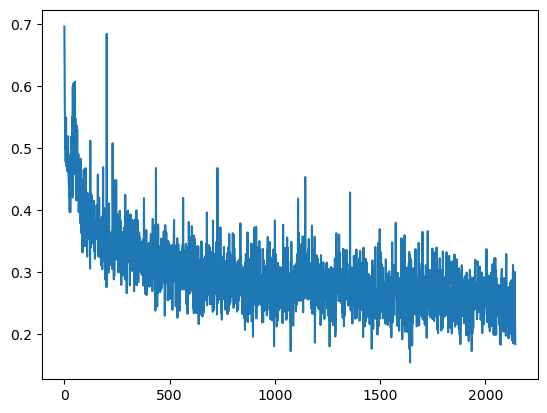

Step: 1/307  |  Train loss: 0.2348  |  Train AUC: 0.9289


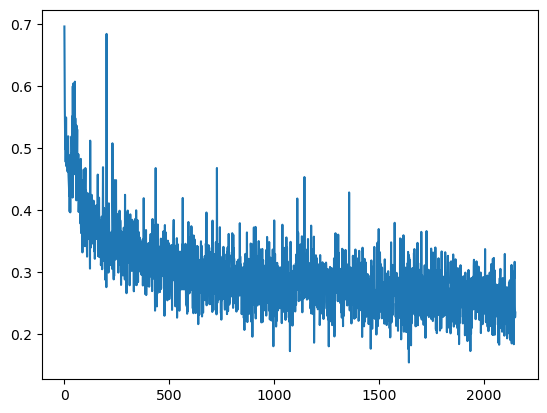

Step: 101/307  |  Train loss: 0.2365  |  Train AUC: 0.9414


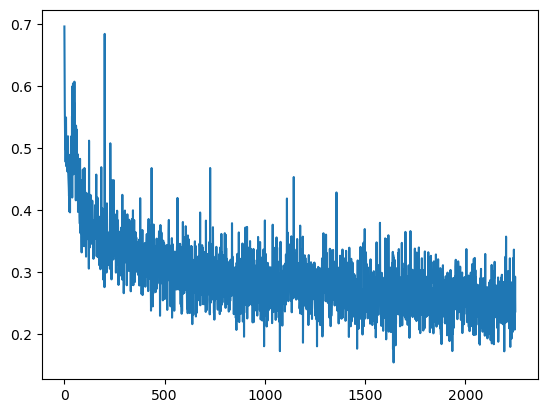

Step: 201/307  |  Train loss: 0.1896  |  Train AUC: 0.9623


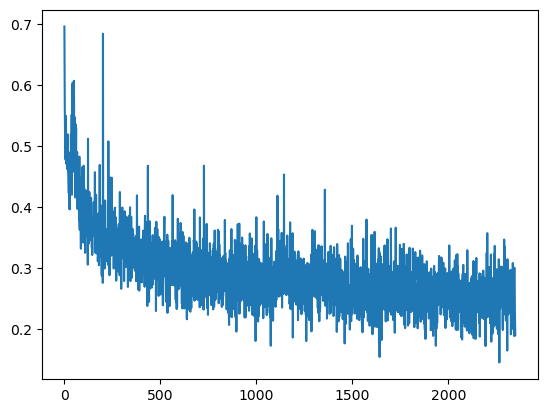

Step: 301/307  |  Train loss: 0.2708  |  Train AUC: 0.7347


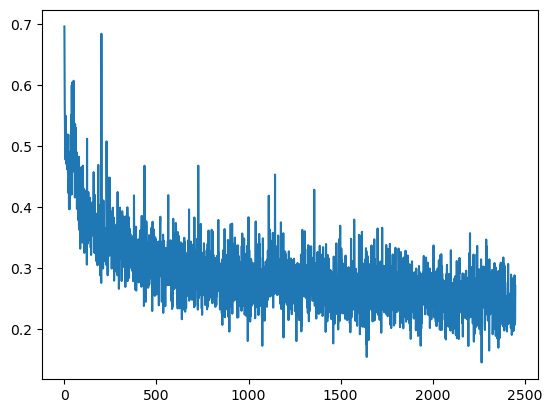

Step: 1/307  |  Train loss: 0.1891  |  Train AUC: 0.9570


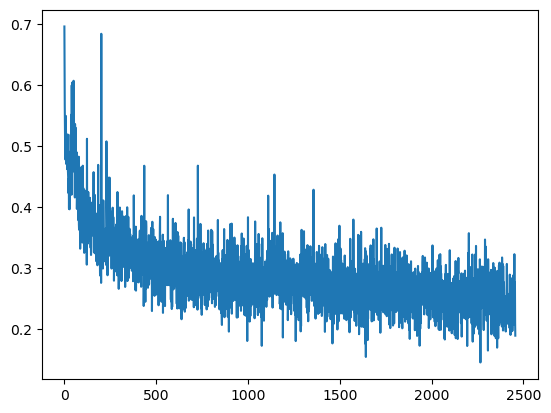

Step: 101/307  |  Train loss: 0.2117  |  Train AUC: 0.9495


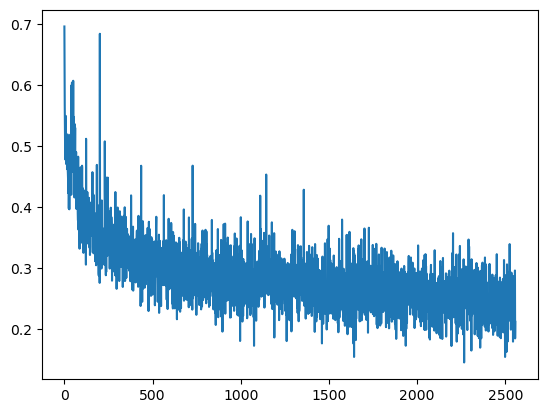

Step: 201/307  |  Train loss: 0.2085  |  Train AUC: 0.7803


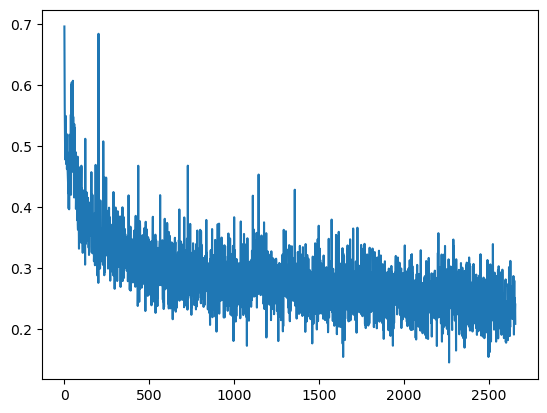

Step: 301/307  |  Train loss: 0.2279  |  Train AUC: 0.9416


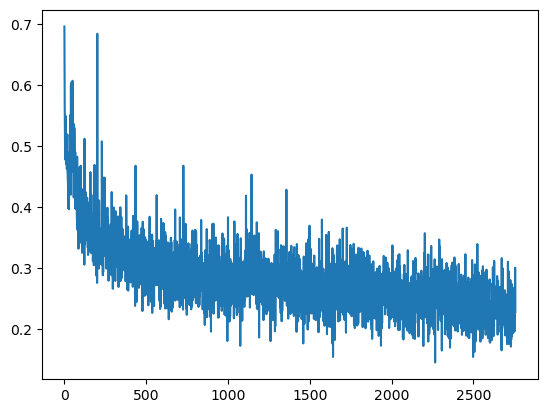

Step: 1/307  |  Train loss: 0.2495  |  Train AUC: 0.7693


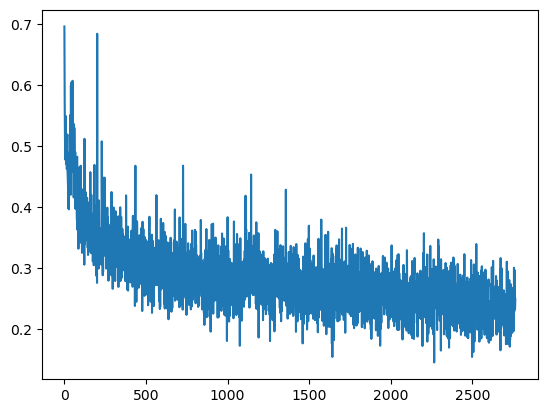

Step: 101/307  |  Train loss: 0.2125  |  Train AUC: 0.9406


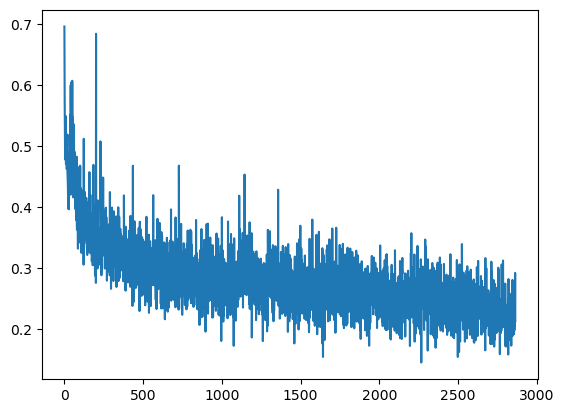

Step: 201/307  |  Train loss: 0.1930  |  Train AUC: 0.9558


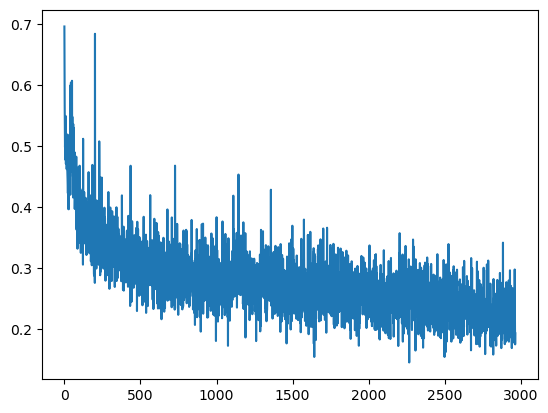

Step: 301/307  |  Train loss: 0.2758  |  Train AUC: 0.9111


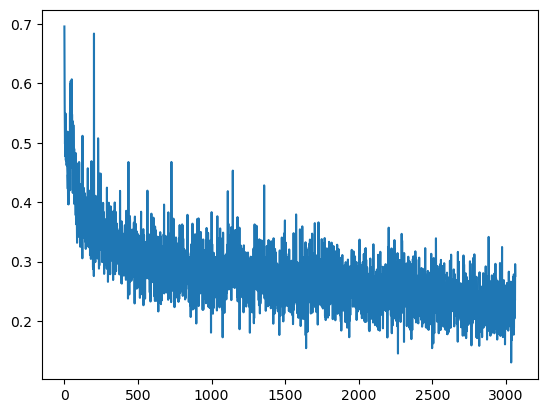

In [10]:
t = 0
steps_per_epoch = len(train_loader)
T_max = steps_per_epoch*epochs
T_0 = T_max/5 
learning_rates = []
train_losses = []

for epoch in range(epochs):
    for i, (signal, labels) in enumerate(train_loader):
        signal = signal.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(signal)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        if t <= T_0:
            lr = 10**(-4) + (t/T_0)*lr_max  
        else: 
            lr = lr_max*np.cos((np.pi/2)*((t-T_0)/(T_max-T_0))) + 10**(-6) 

        for g in optimizer.param_groups:
            g['lr'] = lr 
        learning_rates.append(lr)
        train_losses.append(loss.item())
        optimizer.step()
        t+=1
        
        train_AUC = ml_auroc(outputs, labels.int())
        writer.add_scalar("Train_Loss", loss, t)
        writer.add_scalar("Learning rate", lr, t)
        writer.add_scalar("Batch Train AUC", train_AUC, t)

        if i%100 == 0:
            print(f"Step: {i+1}/{len(train_loader)}  |  Train loss: {loss.item():.4f}  |  Train AUC: {train_AUC:.4f}")
            fig = plt.figure()
            plt.plot(train_losses)
            plt.show()

    # model.eval()
    # test_auc = 0
    # with torch.no_grad():
    #     for i, (signal, labels) in enumerate(test_loader):
    #         signal = signal.to(device); labels = labels.to(device)
    #         outputs = model(signal)
    #         test_auc += ml_auroc(outputs, labels.int())
    #     test_auc /= len(test_loader)
    # writer.add_scalar("Test AUC", test_auc, epoch)

In [11]:
model.eval()
test_Auc = 0
with torch.no_grad():
    for i, (signal, labels) in enumerate(test_loader):
        signal = signal.to(device); labels = labels.to(device)
        outputs = model(signal)
        test_Auc += ml_auroc(outputs, labels.int())

test_Auc /= len(test_loader)
test_Auc
        

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


tensor(0.8660, device='cuda:0')

In [ ]:
model.parameters()